In [1]:
''' 
    This code is developed for the Python workshop at the Winter
    School in Astronomy 2017
    
    @Author : Sayantan Auddy
    Created : 7 Feb 2017
    
    Modified : 14 Feb 2017
    
    Objective : To the study the probability denstiy 
    distribution of mass for ONC data.

'''

## for any python documentation and FAQs
## visit https://www.python.org/doc/

## Importing the numerical module numpy
## https://docs.scipy.org/doc/ 
import numpy as np  

## Importing matplotlib for plotting
## visit http://matplotlib.org/contents.html
import matplotlib.pyplot as plt 

## Scipy is scientific python 
from scipy.special import erfc

## to get the plot in a separate GUI window (not needed for 
## other platform)
# %matplotlib qt  

## this command plots the matplotlib figures in line with the 
## code this works by default in jupyter 
%matplotlib inline  

# That gives a interactive version within the notebook
# %matplotlib notebook

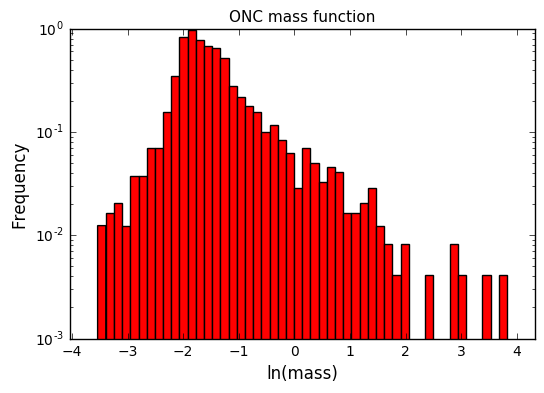

In [6]:
## read the data file in fp
## fp is a file handle
fp = open ("ONCdata.dat",'r')

## Declaring an empty list to store the data from the .dat file
mass =[]

## Reading the data from a .dat file line by line
## please refer to the link for details  
## http://stackoverflow.com/questions/4071396/split-by-comma
## -and-strip-whitespace-in-python

## Python reads top to bottom left to right.
for line in fp:
    #print(line.strip().split())
    #print(line.strip())
## t is a list. You can check by type(variable)
    t = line.strip().split()              
    for value in t:
        # the func append helps to modify the array storage
        # python returns a string, but we need a floating point
        mass.append(float(value))         

## closing the file after it reads in the data *important 
fp.close()  

##to convert mass python list to numpy array list for easy manipulation
mass_array = (np.asarray(mass))           


############################################################
'''
    Visualisng the nature of the data by ploting a histogram

'''

##declaring the bin size for the histogram
binsize = 50                              
plt.figure(1)

## this gives the latex text for the plots
# plt.rc('text',usetex=True)               

## Binning in d ln(mass). Binning can be modified depending 
## on the requirement of the problem
plt.hist(np.log(mass_array),binsize,normed=1,facecolor='red'
         ,cumulative=False) 

## Binning in d(mass) i.e. linear spacing
# plt.hist(mass_array,binsize,normed=1,facecolor='red'
#          ,cumulative=False) 

## x axis limit
plt.xlim(min(np.log(mass_array))-0.5,max(np.log(mass_array))+0.5) 
## y axis limit
# plt.ylim(-3,3)       
## log scale on the y axis
plt.yscale('log')                         
plt.title ("ONC mass function",fontsize=11)
plt.xlabel("ln(mass)", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.savefig("ONC.png",dpi = 600)
plt.show()

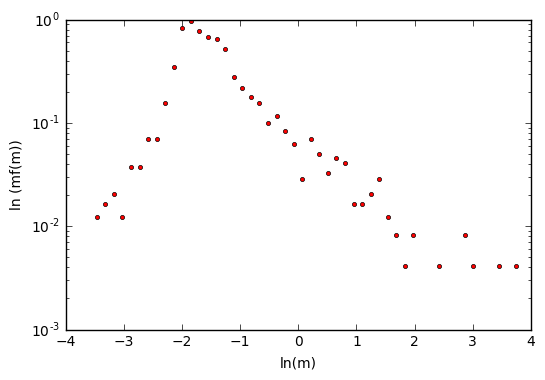

In [16]:
## To fit the histogram using the least square method
## this gives the frequency and the edges of the bins

## important to note we bin in d mass (linearly spaced)
# bincount,bin_edge = np.histogram(mass,binsize,normed=1) 

## important to note we bin in d ln(m) (logarithmically spaced)
##python histogram gives edge and not center? there must be some command!
bincount,bin_edge = np.histogram(np.log(mass_array),binsize,normed=1) 

## bincenter is the value for the center of each bins
bincenter = (bin_edge[1:]+bin_edge[:-1])/2.0
xdata=bincenter[:]
ydata=bincount[:]
plt.figure(2)
# plt.ylim(10**-1,10**3)
plt.ylabel('ln (mf(m))')
plt.xlabel('ln(m)')
plt.plot(xdata,ydata,'ro',markersize=3)
plt.yscale('log')
plt.savefig("ONCMassfunc.png",dpi = 600)

The objective is to fit a Fucntion to the above data set for analysing the slope of the power law tail. 
We shall try to fit MLP (Basu et al 2015)
The MLP function is define as:

f(m) = $\frac{\alpha}{2}\exp{\alpha \mu_{0}+\alpha^{2}\sigma^{2}/2} m^{-(1+\alpha)}
       \times erfc \left({\frac{1}{\sqrt{2}}\left(\alpha\sigma-\frac{\ln(m - \mu_{0})}{\sigma_{0}}\right)}\right)$

In [17]:
## Declaring MLP maximum likelihood function. Please refer to the
## following reference for details.


def MLPMLEfit(params):
    """
        General overview of the function
        This is the maximum likelihhod of the MLP function. 
        Inputs: The data point are loaded as inputs
        Output: On optimising this function it gives the best fit paramters
                alpha, mu_{0} and sigma_{0}
        Reference : Please read section () for details
        Author: Sayantan
    """
    alpha,mu0,sigma0=params
    x = mass_array              # the data is loaded
    p1=(alpha/2.0)*np.exp(alpha*mu0+((alpha*sigma0)**2)/2.0)
    p2=x**(-(1+alpha))
    arg=(1.0/np.sqrt(2.0))*(alpha*sigma0-(np.log(x)-mu0)/sigma0)
    p3=erfc(arg)
    p = p1*p2*p3;
    return sum(-np.log(p))     # retuns the log likelihood. 


########################################################################

## We define the function MLP as mf(m). Notice the difference in the
## power of mass in p2 
##  x is the variable through which we are passing mass.



def MLP(x,*params):
    """ 
        General overview of the function
        This is mf(m) as defined earlier where f(m) = MLP
        Inputs: An array of x values and the parameter 
                alpha, mu_{0} and sigma_{0}
        Output: Evaluate the m f(m) where f(m) is the MLP functiom
        Reference : Basu et al 2015. 
        Author: Sayantan
    """
    alpha,mu0,sigma0=params
    p1=(alpha/2.0)*np.exp(alpha*mu0+((alpha*sigma0)**2)/2.0)
    p2=x**((-alpha))
    arg=(1.0/np.sqrt(2.0))*(alpha*sigma0-(np.log(x)-mu0)/sigma0)
    p3=erfc(arg)
    p = p1*p2*p3;
    return(p)    # returns m f(m)

In [18]:
''' 
    We will use least square method to fit MLP to the mass data of 
    the ONC cloud. Curve Fit is the funtion in python
    which uses non-linear least squares to fit a function, f, to data.
    A statistical method used to determine a line of best fit
    by minimizing the sum of squares created by a mathematical function.
    A "square" is determined by squaring the distance between a data point 
    and the regression line.

'''

def MLPcurvefit(x,alpha,mu0,sigma0):
    """
        General overview of the function
        This is MLP function f (m) which is used to fit the data using 
                least square method 
        Inputs: An array of x values and the parameter 
                alpha, mu_{0} and sigma_{0}
        Output: Best fit parameters
        Reference : Basu et al 2015. 
        Author: Sayantan
    """
    p1=(alpha/2.0)*np.exp(alpha*mu0+((alpha*sigma0)**2)/2.0)
    p2=x**(-(1+alpha))
    arg=(1.0/np.sqrt(2.0))*(alpha*sigma0-(np.log(x)-mu0)/sigma0)
    p3=erfc(arg)
    p = p1*p2*p3;
    return(p)

## imoporting the curve_fit function from scipy module
from scipy.optimize import curve_fit


##important to note we bin in d(m)
bincount_ls,bin_edge_ls = np.histogram(mass_array,binsize,normed=1) 

# bincenter is the value for the center of each bins
bincenter_ls = (bin_edge_ls[1:]+bin_edge_ls[:-1])/2.0
fitParams,fitCov=curve_fit(MLPcurvefit,bincenter_ls,
                           bincount_ls,bounds=([0.,-3,0,],[5., 5., 5.]))
print('alpha=%f\n'%(fitParams[0]))
print('mu_0=%f\n'% (fitParams[1]))
print('sigma_0=%f\n'%(fitParams[2]))

alpha=2.071894

mu_0=-1.428513

sigma_0=0.129992



In [21]:
'''
    For optimization we shall use
    scipy.optimize.differential_evolution

    Finds the global minimum of a multivariate function. 
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than 
    conventional gradient based techniques.
    For detials: 
    https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/
    scipy.optimize.differential_evolution.html

'''
## We want to find the optimized value for the parameters alpha,
## mu0 and sigma0 for the best
## fit MLP fucntion.

## importing the differential_evolution routine from scipy module
from scipy.optimize import differential_evolution
## defining the possible bounds for the values of alpha, mu0 and sigma0
bounds = [(1, 5), (-3, 1),(0.01,2)]

##np.random.seed(1)   # fixed seed gives the same values on every run

result = differential_evolution(MLPMLEfit, bounds)
## result.x, result.fun
print("global minimum: x = [%.3f, %.3f,%.3f], f(x0) = %.3f\n" % 
      (result.x[0], result.x[1],result.x[2],result.fun))
print('alpha  = %.3f\n'%(result.x[0]))
print('mu0    =%.3f\n'%(result.x[1]))
print('sigma_0= %.3f\n'%(result.x[2]))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log


global minimum: x = [1.549, -2.085,0.360], f(x0) = -699.080

alpha  = 1.549

mu0    =-2.085

sigma_0= 0.360



In [22]:
'''
For optimization we shall use
scipy.optimize import basinhopping
For detials: 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.
optimize.basinhopping.html

'''
from scipy.optimize import basinhopping

## intial guess values of the parameter alpha, mu0, sigma0
x0 = [3., 0.1,0.1]

## defining the possible bounds for the values of alpha, mu0 and sigma0

xmin = [1.,-3.,0.]          # lower bound
xmax = [5.,1., 1.]          # upper bound

## rewrite the bounds in the way required by L-BFGS-B
bounds = [(low, high) for low, high in zip(xmin, xmax)]

BHsettings = dict(method="L-BFGS-B", bounds=bounds)

ret = basinhopping(MLPMLEfit,x0,minimizer_kwargs=BHsettings,
                   niter=200,disp=0,niter_success=None)

print("global minimum: x = [%.3f, %.3f,%.3f], f(x0) = %.3f\n" % 
      (ret.x[0], ret.x[1],ret.x[2],ret.fun))
print('alpha  = %.3f\n'%(ret.x[0]))
print('mu0    =%.3f\n'%(ret.x[1]))
print('sigma_0= %.3f\n'%(ret.x[2]))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log
//anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
//anaconda/lib/python3.5/site-packages/scipy/optimize/_basinhopping.py:284: RuntimeWarning: invalid value encountered in double_scalars
  w = min(1.0, np.exp(-(energy_new - energy_old) * self.beta))


global minimum: x = [2.157, -1.836,0.508], f(x0) = nan

alpha  = 2.157

mu0    =-1.836

sigma_0= 0.508



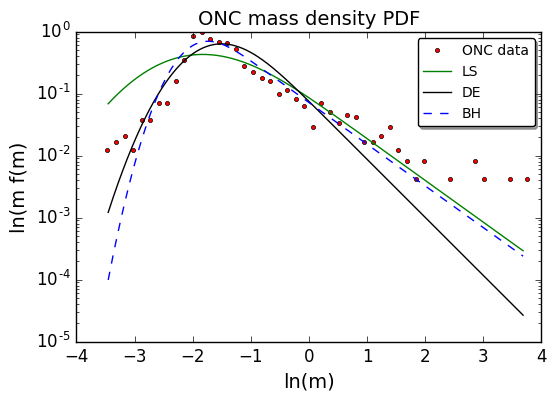

In [14]:
'''
    Plotting the MLP with the best fit parameters along with
    the ONC data points.

''' 
fitParams[0] = 1.549
fitParams[1] = -2.306813
fitParams[2] = 0.770617
# using the best fit parameters from the curve fit least square method
params_ls = fitParams[0],fitParams[1],fitParams[2]
# using the best fit parmameters from differential evolution optimisation
params_dff = [ret.x[0],ret.x[1],ret.x[2]]
# using the best fit parameters from the basinhopping optimisation
params_bh = result.x[0],result.x[1],result.x[2]

# defining an array of numbers to plot the MLP function
xarray = np.logspace(-1.5,1.6,1000)
# plt.hist(np.log(mass_array),binsize,normed=1,facecolor='blue'
#          ,cumulative=False) 
plt.figure(3)
plt.clf()
plt.plot(xdata,ydata,'ro',markersize=3,label="ONC data")
plt.plot(np.log(xarray),MLP(xarray,*params_ls),'g-',label='LS')
plt.plot(np.log(xarray),MLP(xarray,*params_dff),'k',label='DE')
plt.plot(np.log(xarray),MLP(xarray,*params_bh),'b--',label='BH')        
plt.legend(numpoints=1,fancybox=True,shadow=True,fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title (r'ONC mass density PDF',fontsize=14)
plt.xlabel('ln(m)',fontsize=14)
plt.ylabel('ln(m f(m)',fontsize=14)
# plt.text(-2,0.001,r'$\sin(x)$',fontsize=12)
plt.yscale('log')
plt.savefig("MLPfits",dpi = 600)
plt.show()